147 [3.04475063 2.93747551 2.8272429  3.05361762 0.10794862 0.37361689
 2.60362345 2.79785571 1.89967427 2.47257323 2.22846444 2.67784349
 3.04447456 3.00124689 2.89748187 3.07950915 3.04591213 2.46492109
 0.22359735 0.80160753 0.19291885 1.7601888  0.55700694 2.79659342
 2.64171127 0.13954545 3.30981934 2.93587333 2.84044329 2.34376004
 2.65312186 2.15025434 1.79110278 1.06122151 0.75456773 2.19053739
 2.74082558 3.10967008 0.10962588 1.79999981 2.85048451 3.15896278
 2.82690708 3.0495918  2.78466367 1.25704953 3.22147568 2.6580117
 3.21466842 3.62901538 2.81049594 3.25030021 2.73020088 2.66778268
 0.29867608 1.35045114 3.09380781 2.19857063 1.09227725 1.59568404
 2.22336636 1.2643105  0.19277154 1.19272805 2.2480096  2.69255449
 3.17908753 2.90933491 2.44052503 2.40951617 2.5775556  2.93228905
 3.42607812 3.33833299 2.87333688 2.72227168 2.92897413 2.42132244
 3.48101193 3.385385   0.16913256 0.22499368 2.65830238 1.7338392
 2.97734206 2.44941346 3.18655585 2.81484523 2.52217086 2.29

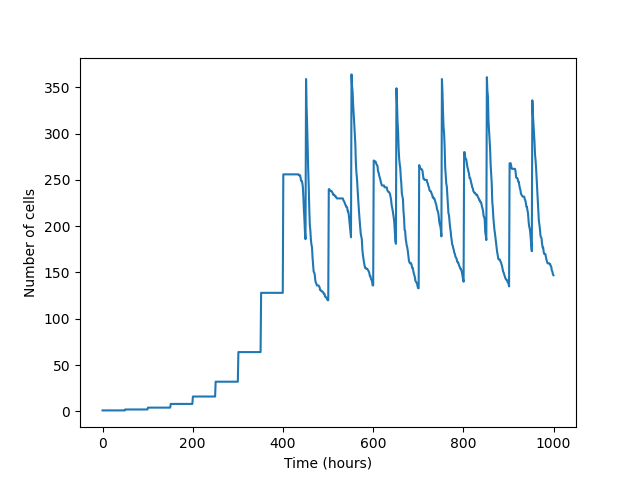

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 10 12:32:25 2022

@author: Anton Grisheshckin
"""
#%%Importing packages#
import numpy as np
import matplotlib.pyplot as plt
#%% Model variables#
class modelvar :
    # Hill parameters    
    n = 3  # Hill function power in g eqn
    k1 = 2 #[AU]
    k2 = 2 #[AU]
    k3 = 0.1 #[AU]
    ################
    ψ = 0.1 # Max amplification for h [AU]hr^-1
    γ1 = 0.1 #Dilution rate hr^-1
    γ2 = 0.1
    I = 0 # dsRNA trigger [AU]hr^-1
    σ1 = 0.02 # Noise amplitudes hr^-1/2
    σ2 = 0.02 
    #################
    divcelltime= 50 # time between cell divisions in hr
    cellnum = 1 #initial number of cells
    Vtot = 200 # total synthesis "chemical" available 
##########################
#%%Deterministic part of the code#
def Hill(top, bottom, power):
    "Creates a Hill function"
    return (top**power)/(top**power+bottom**power)
#%%Stochastic part of the code #

def mu1(g: float,h : float,  _t: float, MaxAmpl) -> float:
    """
    Implement the drift part of the dg equation
    """
    return (modelvar.I+MaxAmpl*Hill(g,modelvar.k1,modelvar.n)*Hill(modelvar.k2,h,1)-modelvar.γ1*g)

def mu2(g: float, h : float,  _t: float) -> float:
    """
    Implement the drift part of the dh equation
    """
    return (modelvar.ψ*(g/(modelvar.k3+g))-modelvar.γ2*h)
def sigma1(g: float, h:float,  _t: float) -> float:
    """
    Implement the BM part of dg equation
    """
    return modelvar.σ1 * g

def sigma2(g: float, h:float,  _t: float) -> float:
    """
    Implement the BM part of dh equation
    """
    return modelvar.σ2 * h

def dW1(delta_t: float) -> float:
    """
    Sample a random number at each call.
    """
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

def dW2(delta_t: float) -> float:
    """
    Sample a random number at each call independent of dW1.
    """
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))
    
def splitting_algorithm(Sim_time,Time_step,Record_step,cell_division_time,initial_cell_num,g_init,h_init,crit_value_g):
   """
   *Sim time*: Simulation run time in hrs 
   *Time_step* : Timestep of the algorithm in hours
   *Record_step* : The timestep used for recording of the data (hr), must be a multiple of Time_step
   *crit_value_g* The critical value after which a cell differentiates
   """
   #Algorithm for the problem#
   #Probably wise to do it in time steps as cells divide along the way
   DT=Time_step
   T=0
   RecordT=0
   time_since_last_division=0
   cellnum=initial_cell_num
   differentcellnum=0 # Numnber of differentiated cells
   #Creating arrays to record different concentrations of chemicals in each cell#
   cell_array_g=g_init*np.ones(cellnum)
   cell_array_h=h_init*np.ones(cellnum)
   #Creating arrays to record data#
   timearray=[0]
   cellnumarray=[1]
   diffcellarray=[0]
   ##############################################################################
   while T<Sim_time :
       #Checking whether cells should divide#
       if time_since_last_division > cell_division_time :
           cellnum=cellnum*2
           time_since_last_division=0-DT
           cell_array_g=np.repeat(cell_array_g,2)
           cell_array_h=np.repeat(cell_array_h,2)
       #####################################
       L=len(cell_array_g)
       cost=sum(cell_array_g)
       i=0
       while i<L :
           new_g=cell_array_g[i] + mu1(cell_array_g[i],cell_array_h[i],T,(modelvar.Vtot/cost)) * DT + sigma1(cell_array_g[i],cell_array_h[i],T) * dW1(DT)
           new_h=cell_array_h[i] + mu2(cell_array_g[i],cell_array_h[i],T)*DT + sigma2(cell_array_g[i],cell_array_h[i],T)*dW2(DT)
           cell_array_g[i]=new_g
           cell_array_h[i]=new_h
           if cell_array_g[i]<crit_value_g :
               differentcellnum=differentcellnum+1
               cell_array_g=np.delete(cell_array_g,i)
               cell_array_h=np.delete(cell_array_h,i)
               cellnum=cellnum-1
               i=i-1
               L=len(cell_array_g)
           i=i+1
       #Check if you need to record at this time step#    
       if RecordT>Record_step:
           timearray.append(T)
           cellnumarray.append(cellnum)
           diffcellarray.append(differentcellnum)
           RecordT=0-DT
       #Timestep addition#
       T=T+DT
       RecordT=RecordT+DT
       time_since_last_division=time_since_last_division+DT
       ###################
       
   return(cellnum,cell_array_g,cell_array_h,differentcellnum,timearray,cellnumarray,diffcellarray)
#%%Main body #
a,b,c,d,timearr,cellnumarr,diffnumarr=splitting_algorithm(1000,0.1,1,modelvar.divcelltime,modelvar.cellnum,4,0.1,0.1)

print(a,b,c,d)
plt.plot(timearr,cellnumarr)
plt.xlabel("Time (hours)")
plt.ylabel("Number of cells")
plt.show()